In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

from nsec.datasets.swiss_roll import get_swiss_roll
from nsec.datasets.two_moons import get_two_moons
import jax
import jax.numpy as jnp
from jax import ops
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from functools import partial

tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


## Comparing Langevin and MALA from TFP

In [2]:
dist = get_swiss_roll(.5, 2048)
score = jax.grad(dist.log_prob)

num_results = int(20e3)
num_burnin_steps = int(1e3)
init_samples = dist.sample(10000, seed=jax.random.PRNGKey(0))

/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
kernel_ulangevin = tfp.mcmc.UncalibratedLangevin(
        target_log_prob_fn=dist.log_prob,
        step_size=0.1)

samples_ulangevin, is_accepted_ulangevin = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_ulangevin,
      #trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(3))

/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/_jax/sample.py:314: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '
/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/_jax/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [4]:
kernel_mala = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=dist.log_prob,
        step_size=0.1)

samples_mala, is_accepted_mala = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_samples[1],
      kernel=kernel_mala,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

0.97775 accepted


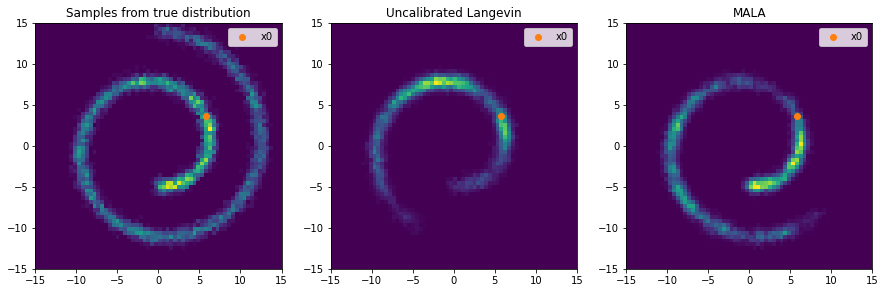

In [5]:
plt.figure(figsize=(15,5))

plt.subplot(131)
hist2d(init_samples[:,0], init_samples[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Samples from true distribution')
legend()
plt.subplot(132)
hist2d(samples_ulangevin[:,0], samples_ulangevin[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('Uncalibrated Langevin')
legend()
plt.subplot(133)
hist2d(samples_mala[is_accepted_mala,0], samples_mala[is_accepted_mala,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1,0], init_samples[1,1], label='x0', color='C1')
title('MALA')
legend()

print('{} accepted'.format(len(jnp.where(is_accepted_mala)[0])/num_results))

## Langevin dynamics

In [6]:
@jax.jit
def update_langevin(i, args):
    samples, step_size, seed = args
    
    seed, key, _ = jax.random.split(seed, 3)
    
    x = samples[i-1]
    
    noise = jax.random.normal(key, shape=x.shape)
    gradient = score(x)
    
    new_x = x + 0.5 * step_size * gradient + noise * jnp.sqrt(step_size)
    
    samples_updated = ops.index_update(samples, i, new_x)
    
    return samples_updated, step_size, seed

@jax.jit
def langevin(init_sample, n_steps=num_results, step_size=.1, seed=jax.random.PRNGKey(5)):
    samples = jnp.zeros((n_steps,2))
    samples = ops.index_update(samples, ops.index[0,:], init_sample)
    langevin_samples, _, _ = jax.lax.fori_loop(1, n_steps, update_langevin, (samples, step_size, seed))
    
    return langevin_samples

## MALA

In [7]:
@jax.jit
def update(args):
    (samples, i, v) = args
    return ops.index_update(samples, i, v)

@jax.jit
def no_update(args):
    (samples, i, v) = args
    return ops.index_update(samples, i, samples[i-1])

@jax.jit
def update_mala(i, args):
    samples, acceptance_samples, step_size, seed = args
    
    seed, key1, key2 = jax.random.split(seed,3)
    
    u = samples[i-1]
    
    noise = jax.random.normal(key1, shape=u.shape)
    
    drift_u = 0.5 * step_size * score(u)
    
    v = u + drift_u + noise * jnp.sqrt(step_size)
    
    drift_v = 0.5 * step_size * score(v)
    
    # Metropolis-Hasings
    delta_log_p = dist.log_prob(v) - dist.log_prob(u)
    
    log_v_u = tfd.MultivariateNormalDiag(v + drift_v, jnp.sqrt(step_size) * jnp.ones(u.shape)).log_prob(u)
    log_u_v = tfd.MultivariateNormalDiag(u + drift_u, jnp.sqrt(step_size) * jnp.ones(u.shape)).log_prob(v)

    log_acceptance_correction = log_v_u - log_u_v
    log_acceptance = delta_log_p + log_acceptance_correction
    
    acceptance_ratio = jnp.min([1., jnp.exp(log_acceptance)])
    
    prob = jax.random.uniform(key2)

    acceptance_samples = ops.index_update(acceptance_samples, i, acceptance_ratio)
    
    samples_updated = jax.lax.cond(prob <= acceptance_ratio,
                                   update,
                                   no_update,
                                   (samples, i, v))
    
    return samples_updated, acceptance_samples, step_size, seed

@jax.jit
def mala(init_sample, n_steps=int(20e3), step_size=.1, seed=jax.random.PRNGKey(5)):
    samples = jnp.zeros((n_steps,2))
    acceptance_samples = jnp.ones(n_steps)
    samples = ops.index_update(samples, ops.index[0,:], init_sample)
    
    mala_samples, acceptance_samples, _, _ = jax.lax.fori_loop(1, n_steps, update_mala, (samples, acceptance_samples, step_size, seed))
    
    return mala_samples, acceptance_samples

In [8]:
init = init_samples[1]
custom_langevin = jnp.array(langevin(init))
custom_mala, acceptance_samples = mala(init)
custom_mala = jnp.array(custom_mala)

Text(0.5, 1.0, 'MALA')

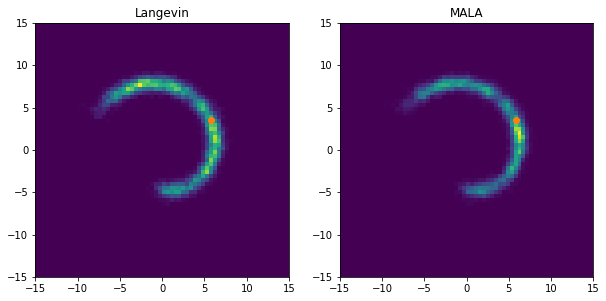

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
hist2d(custom_langevin[:,0], custom_langevin[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init_samples[1, 0], init_samples[1, 1], label='x0', color='C1')
plt.title('Langevin')
plt.subplot(122)
hist2d(custom_mala[:,0], custom_mala[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(custom_mala[0, 0], custom_mala[0, 1], label='x0', color='C1')
plt.title('MALA')

Text(0.5, 1.0, 'acceptance ratios')

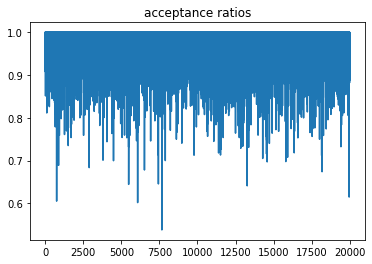

In [10]:
plot(acceptance_samples)
jnp.mean(acceptance_samples)
plt.title('acceptance ratios')